In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

num_classes = 10
num_features = 784

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train/255, x_test/255

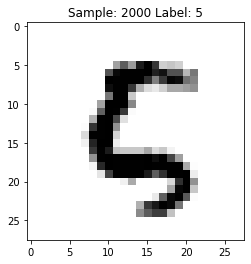

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

def display_sample(num):
    label = y_train[num]
    image = x_train[num].reshape([28, 28])
    plt.title('Sample: %d Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(2000)

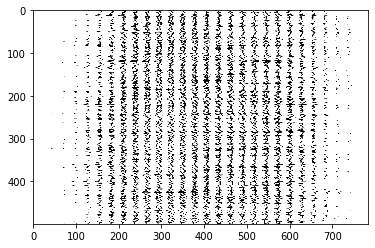

In [14]:
images = x_train[0].reshape([1,784])
for i in range(1, 500):
    images = np.concatenate((images, x_train[i].reshape([1,784])))
plt.imshow(images, cmap=plt.get_cmap('gray_r'))
plt.show()

In [53]:
learning_rate = 0.001
training_steps = 5000
batch_size = 250
display_step = 100

n_hidden = 256


In [54]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(60000).batch(batch_size).prefetch(1)

In [55]:
random_normal = tf.initializers.RandomNormal()

weights = {
    'h':tf.Variable(random_normal([num_features, n_hidden])),
    'out':tf.Variable(random_normal([n_hidden, num_classes])),
}

biases = {
    'b':tf.Variable(tf.zeros([n_hidden])),
    'out':tf.Variable(tf.zeros([num_classes]))
}

In [56]:
def neural_net(inputData):
    
    hidden_layer = tf.add(tf.matmul(inputData, weights['h']), biases['b'])
    
    hidden_layer = tf.nn.sigmoid(hidden_layer)
    
    out_layer = tf.matmul(hidden_layer, weights['out']) + biases['out']
    
    return tf.nn.softmax(out_layer)

In [57]:
def cross_entropy(y_pred, y_true):
    
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

In [58]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

def run_optimization(x, y):
    
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
        
    trainable_variables = list(weights.values()) + list(biases.values())
    
    gradients= g.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [59]:
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [60]:
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("Training epoch: %i, Loss: %f, Accuracy: %f" % (step, loss, acc))

Training epoch: 100, Loss: 194.612701, Accuracy: 0.840000
Training epoch: 200, Loss: 137.119598, Accuracy: 0.864000
Training epoch: 300, Loss: 110.770226, Accuracy: 0.888000
Training epoch: 400, Loss: 115.546921, Accuracy: 0.888000
Training epoch: 500, Loss: 86.777428, Accuracy: 0.908000
Training epoch: 600, Loss: 81.272537, Accuracy: 0.900000
Training epoch: 700, Loss: 86.335640, Accuracy: 0.904000
Training epoch: 800, Loss: 82.003349, Accuracy: 0.900000
Training epoch: 900, Loss: 98.338531, Accuracy: 0.884000
Training epoch: 1000, Loss: 60.723625, Accuracy: 0.936000
Training epoch: 1100, Loss: 62.079426, Accuracy: 0.912000
Training epoch: 1200, Loss: 84.190445, Accuracy: 0.916000
Training epoch: 1300, Loss: 56.680553, Accuracy: 0.936000
Training epoch: 1400, Loss: 78.986160, Accuracy: 0.944000
Training epoch: 1500, Loss: 75.949860, Accuracy: 0.920000
Training epoch: 1600, Loss: 46.057026, Accuracy: 0.944000
Training epoch: 1700, Loss: 75.796127, Accuracy: 0.904000
Training epoch: 180

In [61]:
pred = neural_net(x_test)
print('Test Accuracy: %f' % accuracy(pred, y_test))

Test Accuracy: 0.951200


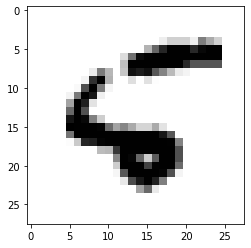

Original Labels: 5
Model prediction: 6


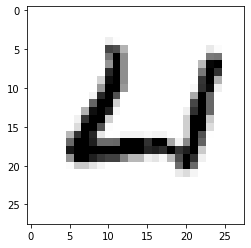

Original Labels: 4
Model prediction: 6


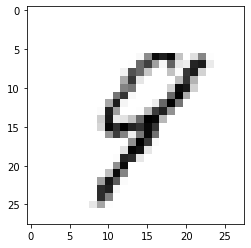

Original Labels: 9
Model prediction: 4


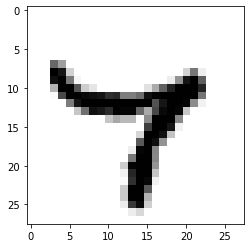

Original Labels: 7
Model prediction: 4


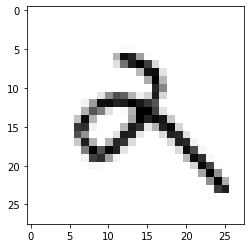

Original Labels: 2
Model prediction: 9


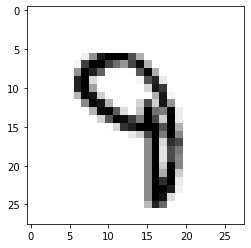

Original Labels: 9
Model prediction: 4


In [62]:
n_images = 200
test_images = x_test[:n_images]
test_labels = y_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    model_prediction = np.argmax(predictions.numpy()[i])
    if (model_prediction != test_labels[i]):
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray_r')
        plt.show()
        print("Original Labels: %i" % test_labels[i])
        print("Model prediction: %i" % model_prediction)